In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [ ]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import get_iteration, tune
from lib.vllm import start_vllm, kill_vllm_workers
import torch
from torchtune.training.metric_logging import WandBLogger
from transformers import AutoTokenizer
import wandb

run_name = "007"
wandb.init(project="grpo-tests", name=run_name, id=run_name, resume="allow")

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(436, 72, 92, 436)

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-19 03:58:10 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 03:58:11 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 03:58:11 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=N

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.01it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.26s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.22s/it]



INFO 02-19 03:58:36 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 03:58:37 worker.py:267] Memory profiling takes 0.81 seconds
INFO 02-19 03:58:37 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 03:58:37 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 03:58:37 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 03:58:37 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 03:59:15 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.92 seconds
INFO 02-19 03:59:16 api_server.py:756] Using supplied chat template:
INFO 02-19 03:59:16 api_server.py:756] None
INFO 02-19 03:59:16 launcher.py:21] Available routes are:
INFO 02-19 03:59:16 launcher.py:29] Route: /

INFO:     Started server process [6593]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 03:59:21 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 03:59:21 metrics.py:455] Avg prompt throughput: 1.1 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 03:59:21 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:59902 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

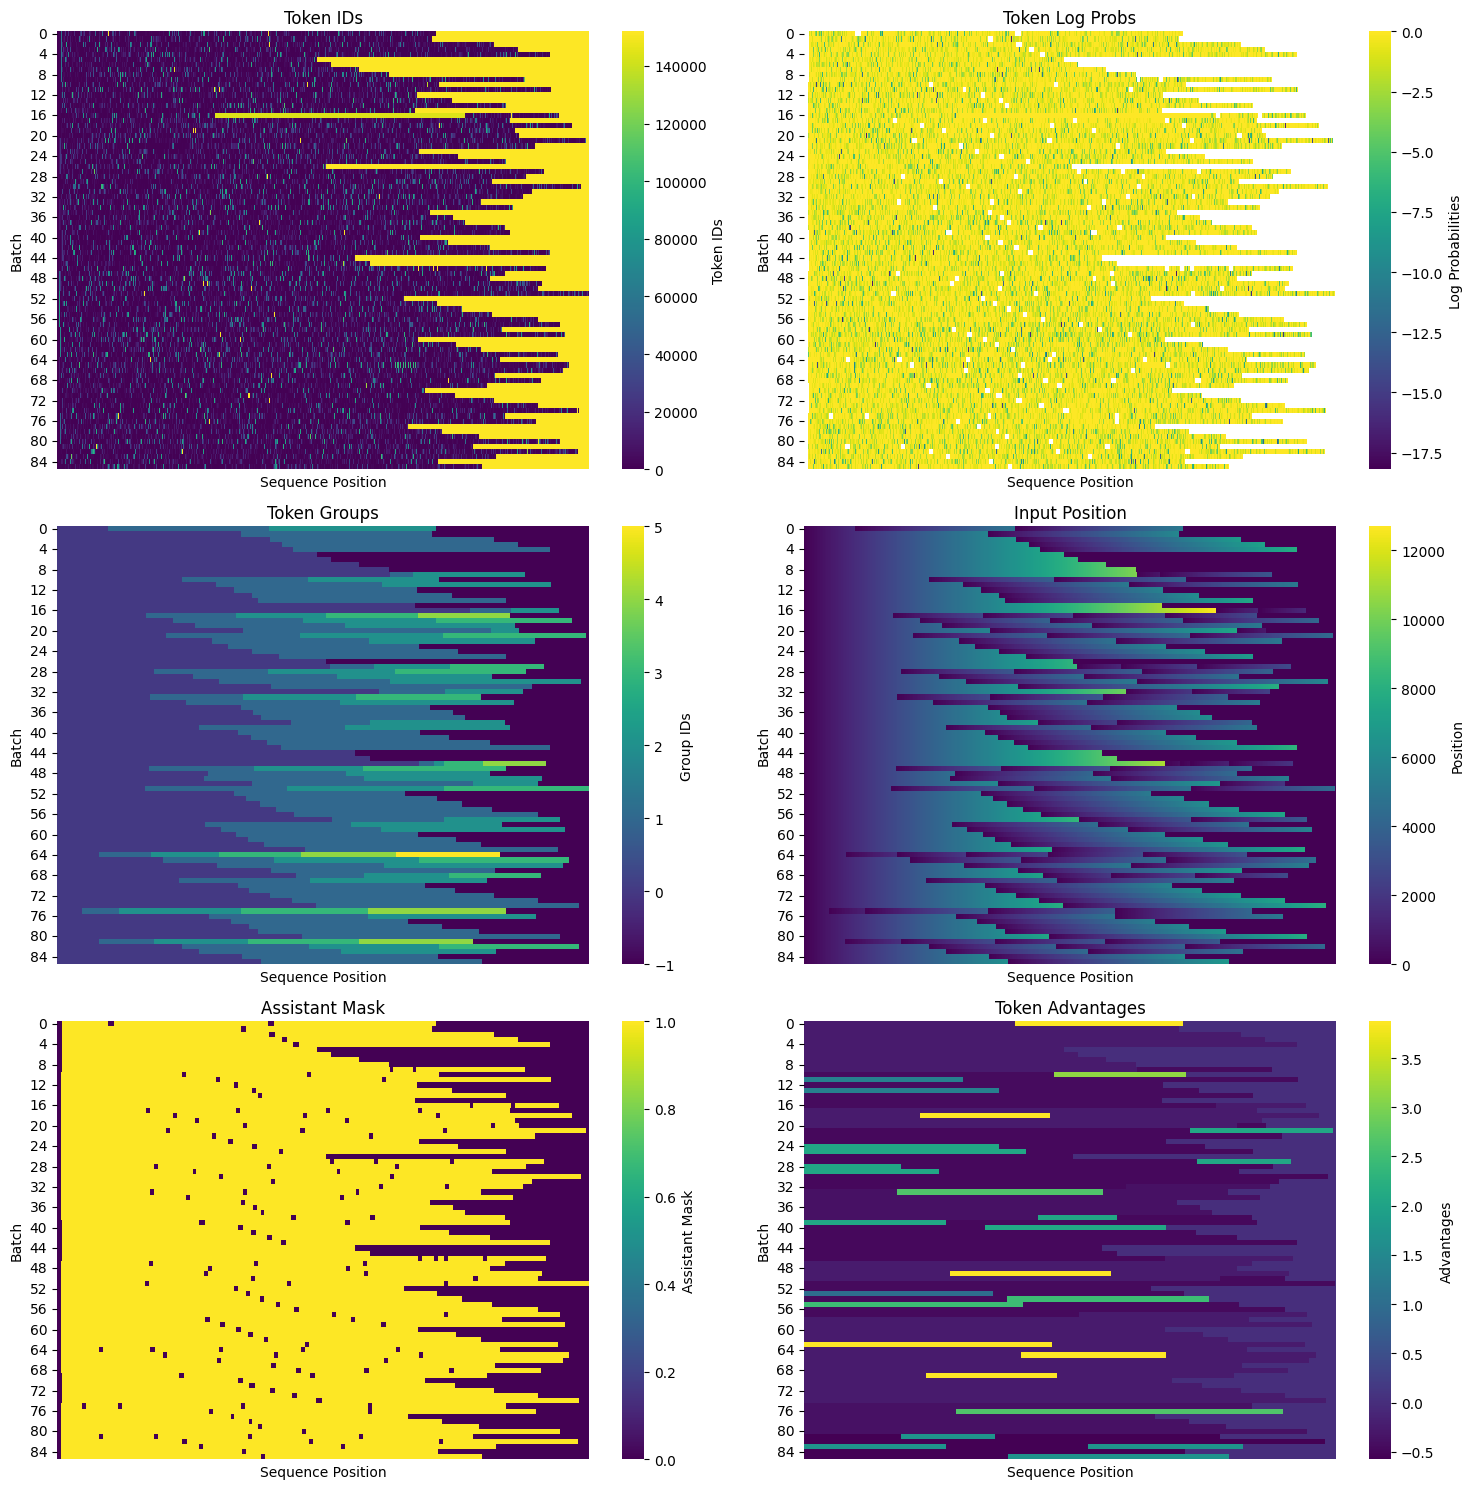

Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d42fae903e9fa07f3e8edb0db00a8d905ba49560
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d6ff9c6d4933688f95f315e3ce08f8e5e28eaeee
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d1fd67ec1bf748c24b244b6efd825ded1b147787
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

Saved iteration 1 model files to ./models/007/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/007/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/007/0001 --port=8000 --api-key=default
INFO 02-19 04:25:59 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 04:26:00 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 04:26:00 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/007/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.06s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.37s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.47s/it]



INFO 02-19 04:26:18 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 04:26:18 worker.py:267] Memory profiling takes 0.69 seconds
INFO 02-19 04:26:18 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 04:26:18 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 04:26:18 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 04:26:18 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 04:26:56 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.22 seconds
INFO 02-19 04:26:57 api_server.py:756] Using supplied chat template:
INFO 02-19 04:26:57 api_server.py:756] None
INFO 02-19 04:26:57 launcher.py:21] Available routes are:
INFO 02-19 04:26:57 launcher.py:29] Route: /

INFO:     Started server process [7767]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 04:26:57 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:52978 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a6e8a4ca700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

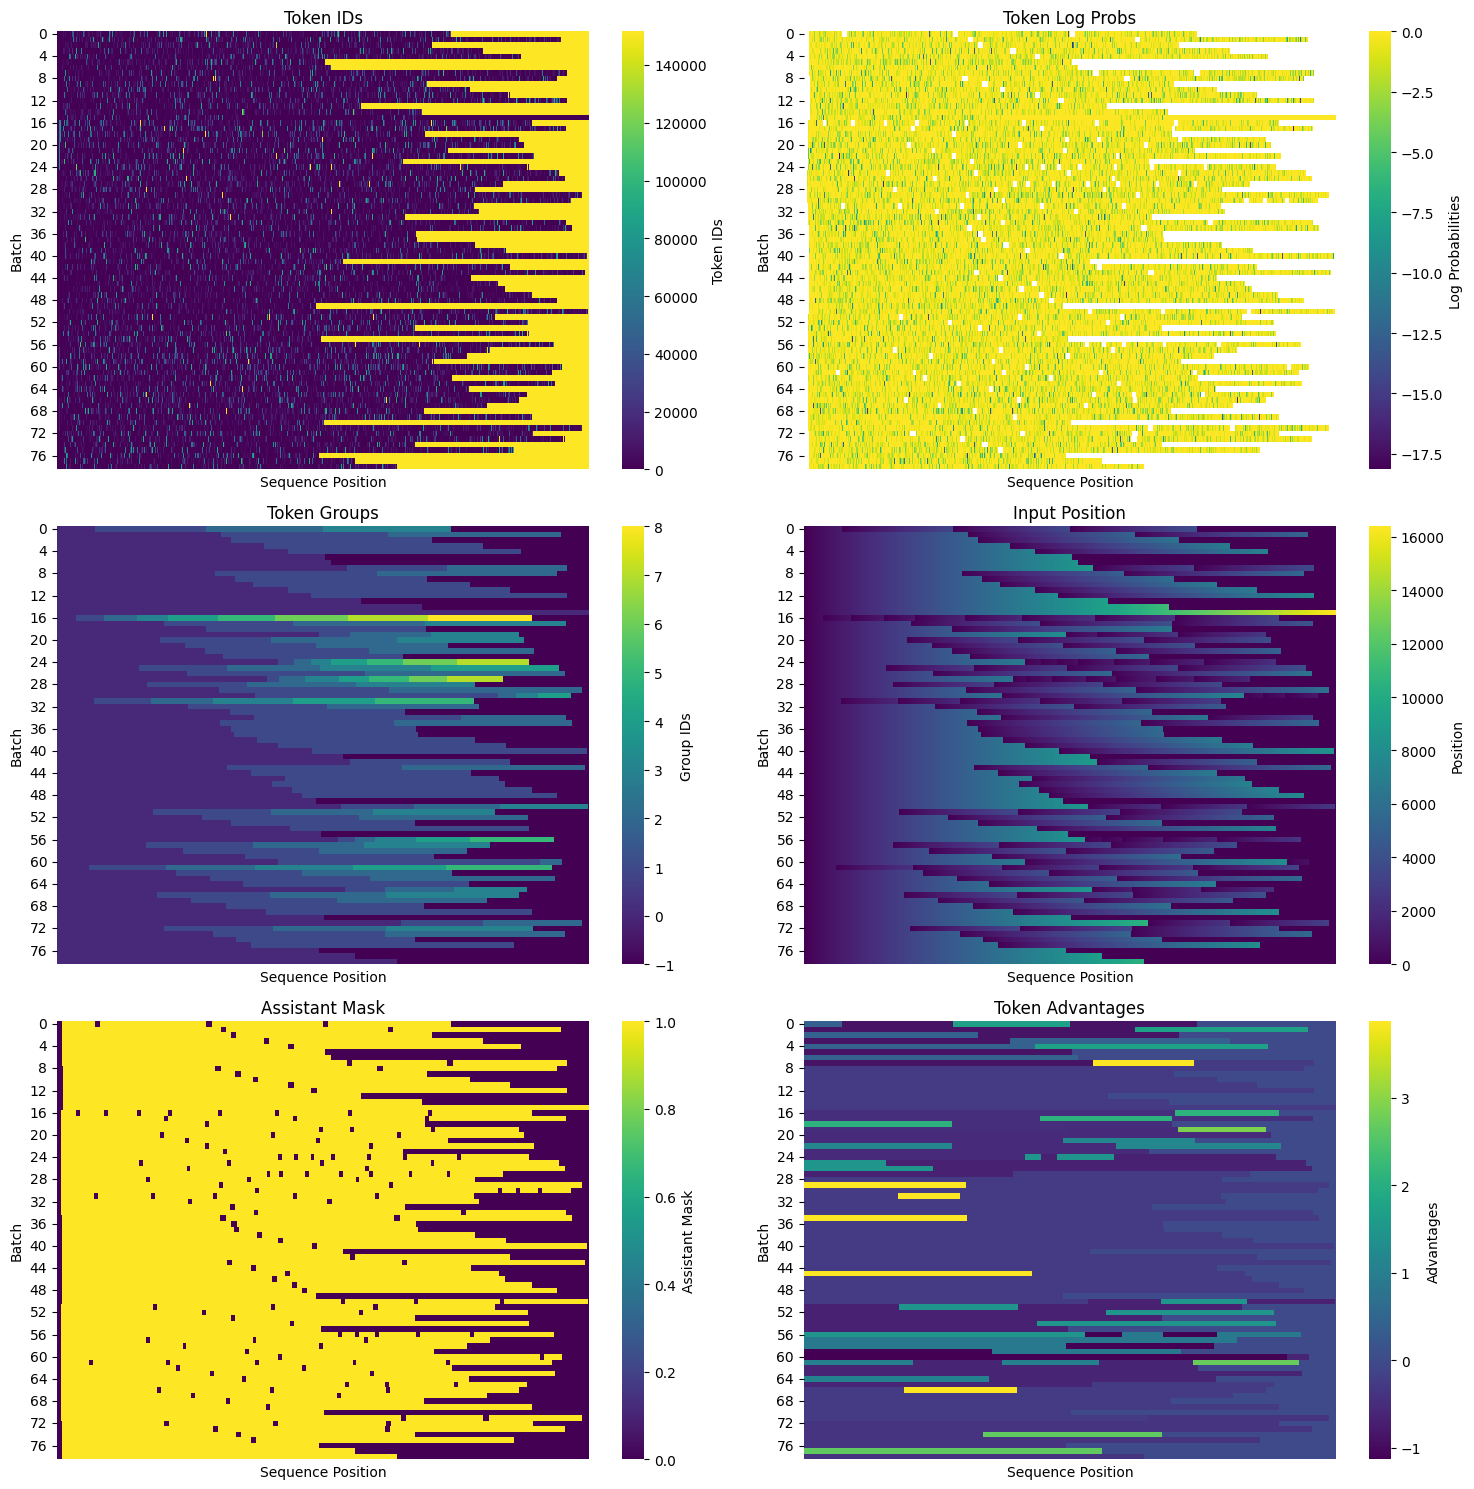

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

Saved iteration 1 model files to ./models/007/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/007/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/007/0001 --port=8000 --api-key=default
INFO 02-19 04:50:39 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 04:50:40 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 04:50:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/007/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:04<00:04,  4.99s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.32s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.42s/it]



INFO 02-19 04:50:58 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 04:50:58 worker.py:267] Memory profiling takes 0.60 seconds
INFO 02-19 04:50:58 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 04:50:58 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 04:50:59 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 04:50:59 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 04:51:36 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.00 seconds
INFO 02-19 04:51:37 api_server.py:756] Using supplied chat template:
INFO 02-19 04:51:37 api_server.py:756] None
INFO 02-19 04:51:37 launcher.py:21] Available routes are:
INFO 02-19 04:51:37 launcher.py:29] Route: /

INFO:     Started server process [8512]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 04:51:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49354 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a6e8a4ca700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

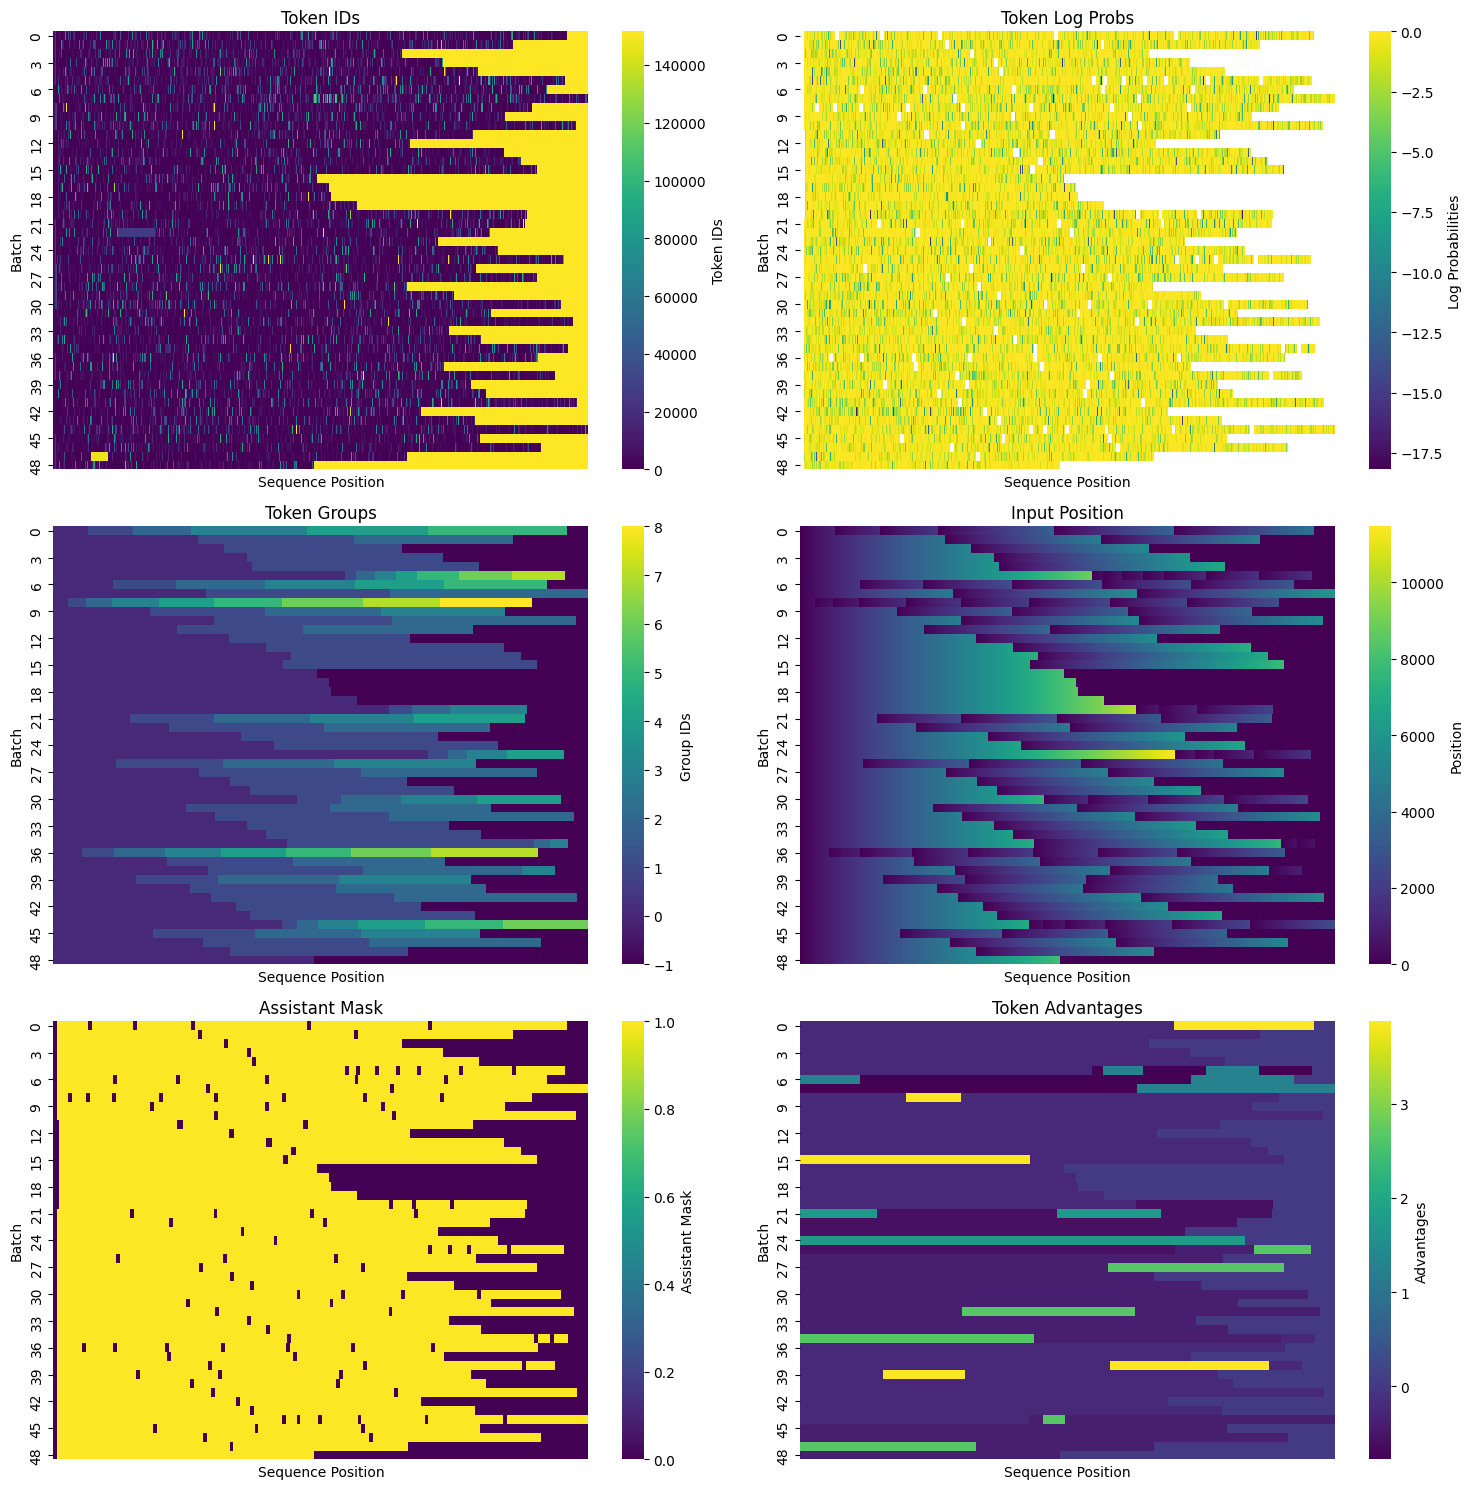

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

Saved iteration 1 model files to ./models/007/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/007/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/007/0001 --port=8000 --api-key=default
INFO 02-19 05:10:18 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 05:10:19 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 05:10:19 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/007/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.05s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.37s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.47s/it]



INFO 02-19 05:10:37 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 05:10:38 worker.py:267] Memory profiling takes 0.60 seconds
INFO 02-19 05:10:38 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 05:10:38 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 05:10:38 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 05:10:38 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 05:11:15 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.04 seconds
INFO 02-19 05:11:16 api_server.py:756] Using supplied chat template:
INFO 02-19 05:11:16 api_server.py:756] None
INFO 02-19 05:11:16 launcher.py:21] Available routes are:
INFO 02-19 05:11:16 launcher.py:29] Route: /

INFO:     Started server process [9278]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 05:11:16 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55312 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a6e8a4ca700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

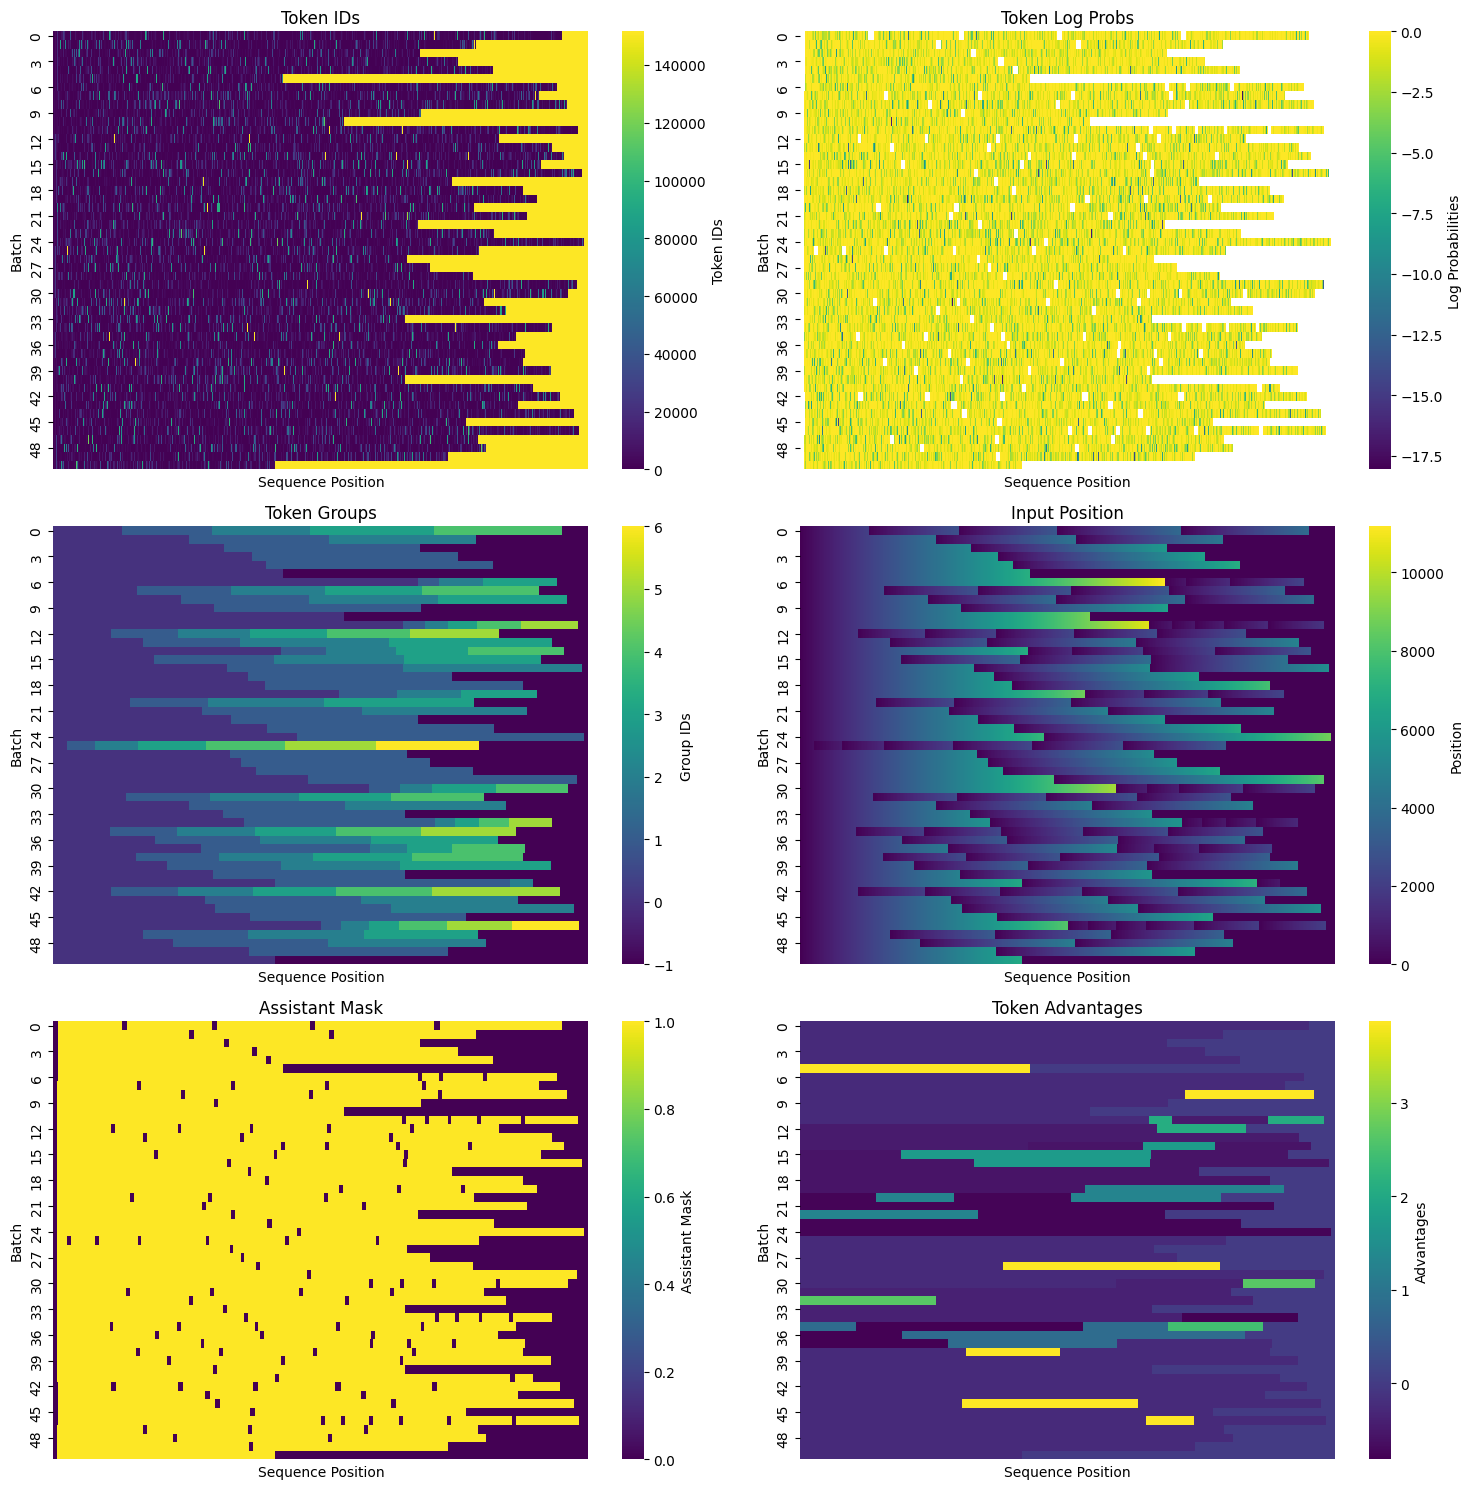

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

Saved iteration 1 model files to ./models/007/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/007/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/007/0001 --port=8000 --api-key=default
INFO 02-19 05:29:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 05:29:19 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 05:29:19 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/007/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.07s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.36s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.47s/it]



INFO 02-19 05:29:37 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 05:29:38 worker.py:267] Memory profiling takes 0.61 seconds
INFO 02-19 05:29:38 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 05:29:38 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 05:29:38 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 05:29:38 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 05:30:15 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.22 seconds
INFO 02-19 05:30:17 api_server.py:756] Using supplied chat template:
INFO 02-19 05:30:17 api_server.py:756] None
INFO 02-19 05:30:17 launcher.py:21] Available routes are:
INFO 02-19 05:30:17 launcher.py:29] Route: /

INFO:     Started server process [10147]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 05:30:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:52096 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a6e8a4ca700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

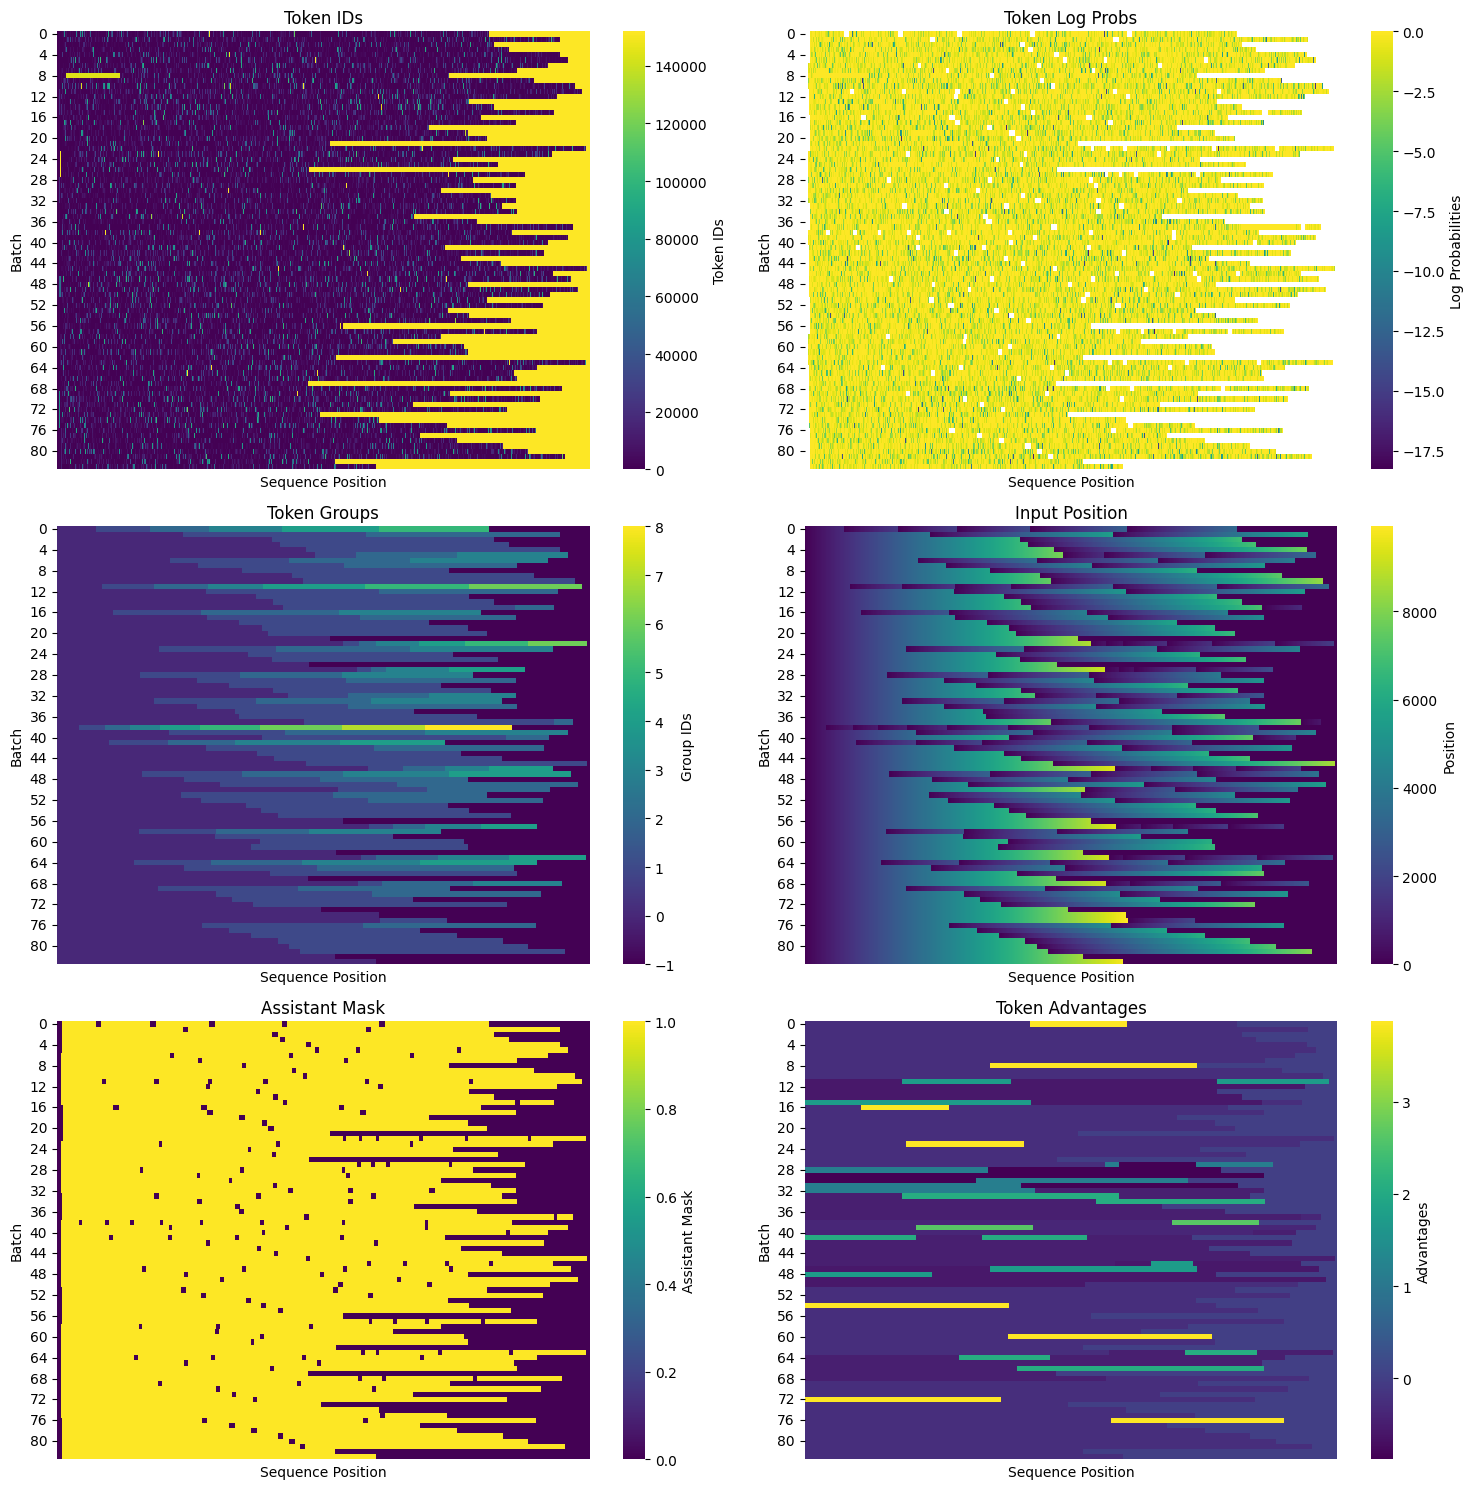

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

Saved iteration 1 model files to ./models/007/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/007/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/007/0001 --port=8000 --api-key=default
INFO 02-19 05:55:25 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 05:55:26 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 05:55:26 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/007/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.14s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.40s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.51s/it]



INFO 02-19 05:55:44 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 05:55:44 worker.py:267] Memory profiling takes 0.70 seconds
INFO 02-19 05:55:44 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 05:55:44 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 05:55:44 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 05:55:44 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 05:56:22 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.05 seconds
INFO 02-19 05:56:23 api_server.py:756] Using supplied chat template:
INFO 02-19 05:56:23 api_server.py:756] None
INFO 02-19 05:56:23 launcher.py:21] Available routes are:
INFO 02-19 05:56:23 launcher.py:29] Route: /

INFO:     Started server process [11178]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 05:56:25 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45898 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a6e8a4ca700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

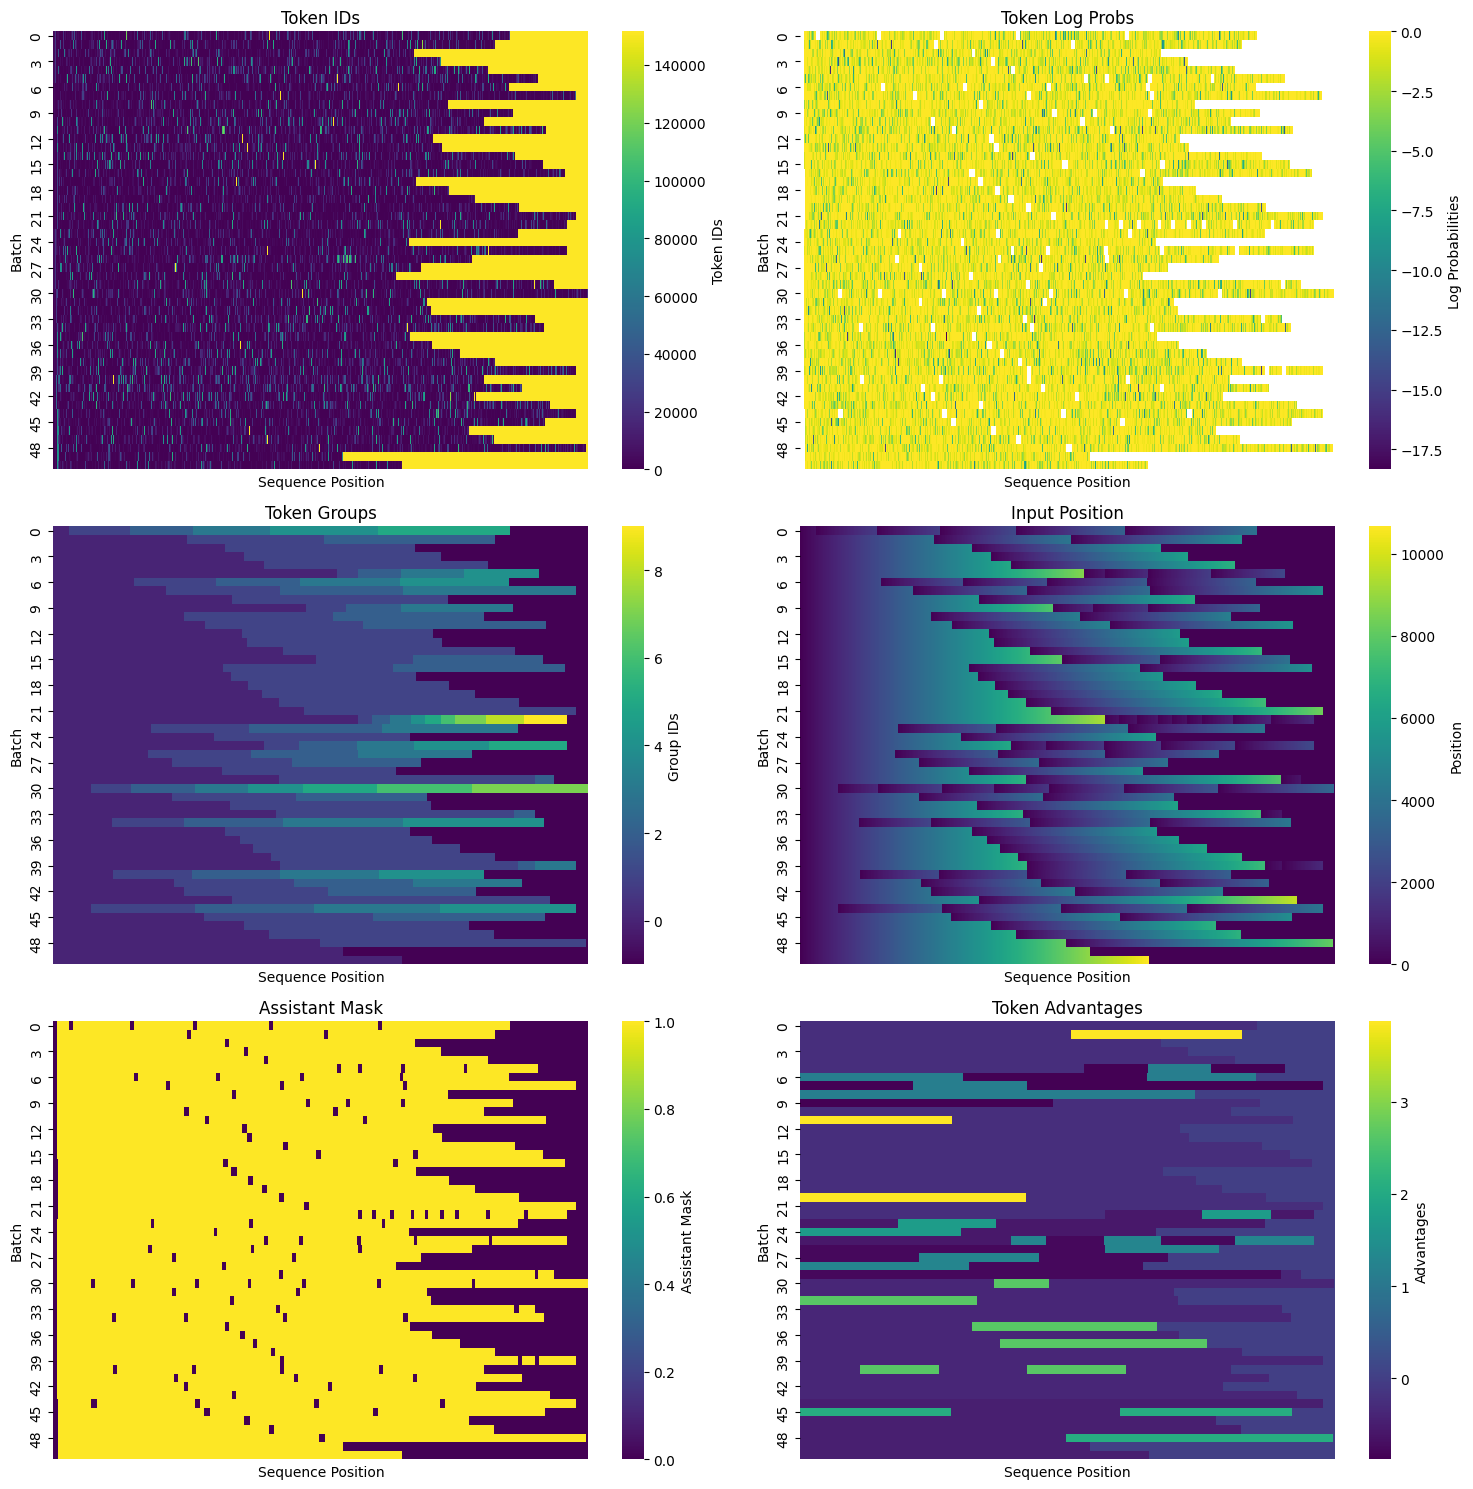

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

Saved iteration 1 model files to ./models/007/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/007/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/007/0001 --port=8000 --api-key=default
INFO 02-19 06:14:49 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 06:14:50 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 06:14:50 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/007/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.10s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.39s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:08<00:00,  4.50s/it]



INFO 02-19 06:15:08 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 06:15:08 worker.py:267] Memory profiling takes 0.60 seconds
INFO 02-19 06:15:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 06:15:08 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-19 06:15:08 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-19 06:15:08 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-19 06:15:46 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 37.90 seconds
INFO 02-19 06:15:47 api_server.py:756] Using supplied chat template:
INFO 02-19 06:15:47 api_server.py:756] None
INFO 02-19 06:15:47 launcher.py:21] Available routes are:
INFO 02-19 06:15:47 launcher.py:29] Route: /

INFO:     Started server process [12006]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 06:15:48 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:59464 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a6e8a4ca700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

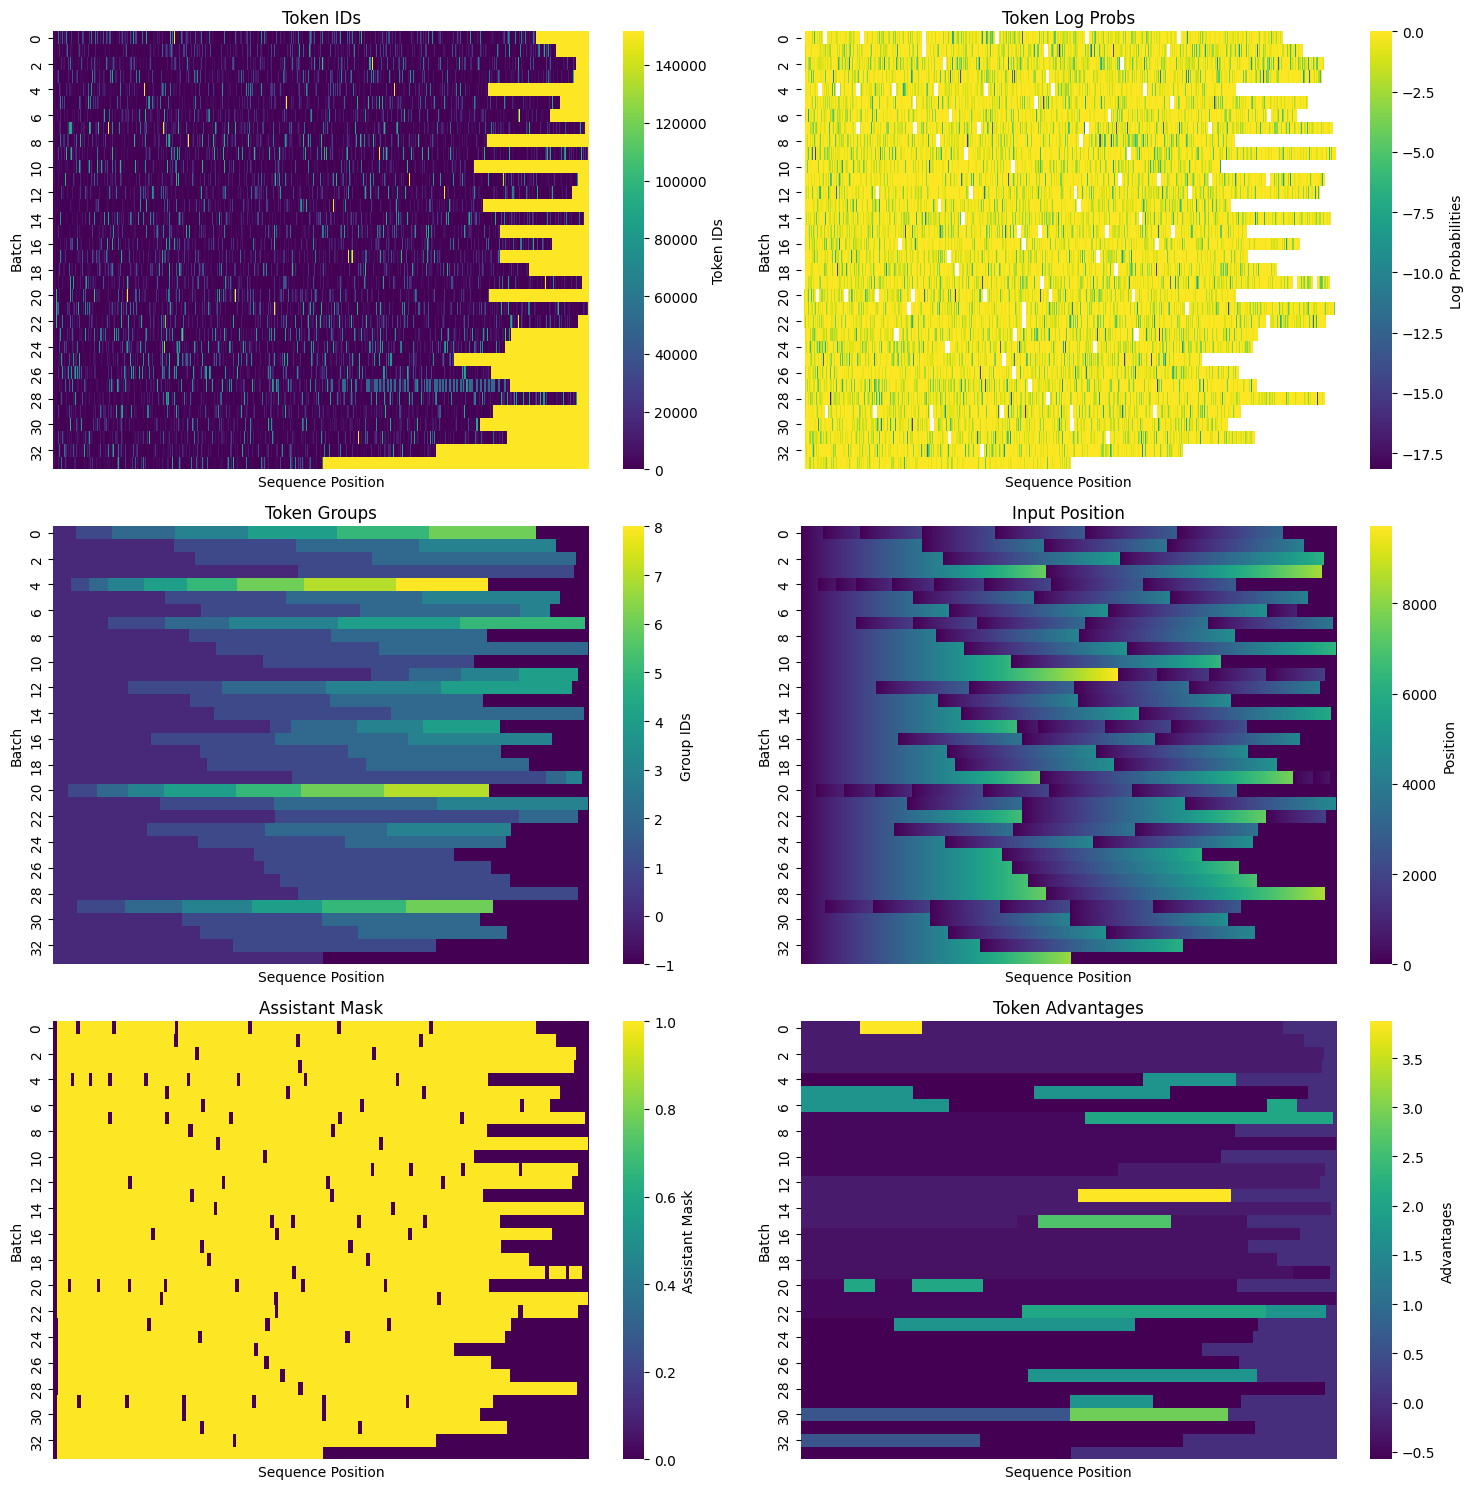

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/007/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/007
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/007/tensors
  num_seque

In [ ]:
model = models.qwen_7b()
model_name = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
seq_len = 16384
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity = 2

for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=512,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=512,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=120 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(vllm.max_concurrent_tokens // 3300)
    offset = i * 32
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + 32)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=16,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": val_stats.completion_tokens / val_stats.usages,
    }
    wandb.log(wandb_data)
    vllm.process.terminate()
    kill_vllm_workers()
    packed_tensors = packed_tensors_from_tokenized_results(
        [
            result
            for results in train_results
            for result in results
            if result.advantage != 0
        ],
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(model.tune_optimizer, lr=1e-6)
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            metric_logger=ComponentConfig(
                WandBLogger,
                project="grpo-tests",
                name=run_name,
                id=run_name,
                resume="must",
            ),
            optimizer=optimizer_config,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()